In [3]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags

In [6]:
class CoreDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, lags: int):
        # start from 1948
        core: pd.DataFrame = df[["CPIAUCSL", "UNRATE", "A191RO1Q156NBEA"]].loc["1948-01-01":]
        
        X = get_lags(core, lags)
        self.y = core[lags:].values
        self.X = X[lags:].values
        
    def __getitem__(self, index):
        return self.y[index], self.X[index]
    
    def __len__(self):
        return len(self.y)
    
    def plot(self):
        plt.plot(self.core)
        plt.show()

full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
coreDataset = CoreDataset(full, lags=3)

In [7]:
trainset = Subset(coreDataset, [i for i in range(600)])
valset = Subset(coreDataset, [i for i in range(601, 700)])
testset = Subset(coreDataset, [i for i in range(701, len(coreDataset))])

trainloader = DataLoader(trainset, batch_size=1, 
                        shuffle=False,
                        sampler=SequentialSampler(trainset))

validationloader = DataLoader(valset, batch_size=1, shuffle=False,
                    sampler=SequentialSampler(valset))

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

In [8]:
class Feedforward(nn.Module):
    
    def __init__(self):
        super(Feedforward, self).__init__()
        self.fc1 = nn.Linear(9, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # no activation at output layer
        return x
    
net = Feedforward()

In [9]:
criterion = nn.MSELoss()
# decreasing the learning rate solved the problem
# https://stackoverflow.com/questions/35540269/keras-giving-same-loss-on-every-epoch
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [10]:
# TODO move to utils
def evaluate_model(net: nn.Module, val_loader: DataLoader, criterion: nn.MSELoss):
    net.eval()
    val_loss = 0
    for i, data in enumerate(val_loader):
        with torch.no_grad():
            y, X = data
            y, X = y.float(), X.float()
            y_pred = net(X)
            loss = criterion(y, y_pred)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def train_one_epoch(net: nn.Module, train_loader: DataLoader, criterion: nn.MSELoss):
    net.train()
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        
        y, X = data
        y, X = y.float(), X.float()
        
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y, y_pred)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_train_loss = epoch_loss / len(train_loader)
    return avg_train_loss
    

def get_average(losses: list):
    total = 0
    for i in losses:
        total += i
    return total/len(losses)


In [32]:
train_losses = []
val_losses = []

# early stopping implementation
# inspired by https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

running_val_loss = []
prev_val_loss = 1000000  # very big number
cnt = 0
patience = 10
ma = 5
percent = 0.99

for epoch in range(5000):
        
    train_loss = train_one_epoch(net, trainloader, criterion)
    val_loss = evaluate_model(net, validationloader, criterion)
    running_val_loss.append(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if epoch % 5 == 0:
        print("[epoch: %d] train loss: %.3f, val loss: %.3f"
              % (epoch + 1, train_loss, val_loss))
    
    avg_val_loss = get_average(running_val_loss)

    if avg_val_loss > percent * prev_val_loss:
        if cnt > patience:
            break
        else:
            cnt += 1
    else:
        cnt = 0  # reset
        
    prev_val_loss = avg_val_loss
    
    # restrict to moving average
    while len(running_val_loss) > ma:
        running_val_loss.pop(0)
            
print("Finished training")
        

[epoch: 1] train loss: 1.271, val loss: 0.271
[epoch: 6] train loss: 0.194, val loss: 0.086
[epoch: 11] train loss: 0.138, val loss: 0.043
[epoch: 16] train loss: 0.112, val loss: 0.028
[epoch: 21] train loss: 0.093, val loss: 0.024
[epoch: 26] train loss: 0.081, val loss: 0.021
[epoch: 31] train loss: 0.073, val loss: 0.019
[epoch: 36] train loss: 0.065, val loss: 0.016
[epoch: 41] train loss: 0.057, val loss: 0.014
[epoch: 46] train loss: 0.052, val loss: 0.013
[epoch: 51] train loss: 0.047, val loss: 0.013
[epoch: 56] train loss: 0.043, val loss: 0.012
[epoch: 61] train loss: 0.039, val loss: 0.012
[epoch: 66] train loss: 0.036, val loss: 0.011
Finished training


In [34]:
# to reset the weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
    
net.apply(init_weights)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Feedforward(
  (fc1): Linear(in_features=9, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=3, bias=True)
)

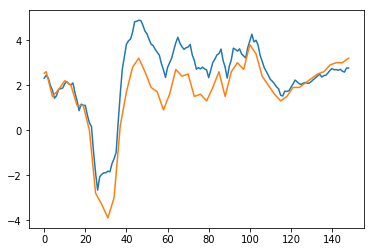

In [11]:
y_pred = []
y_act = []

for i, data in enumerate(testloader):
    y, X = data
    y, X = y.float(), X.float()

    y_pred.append(net(X)[0][2].item())
    y_act.append(y[0][2].item())
    
plt.plot(y_pred)
plt.plot(y_act)

Text(0, 0.5, 'Loss')

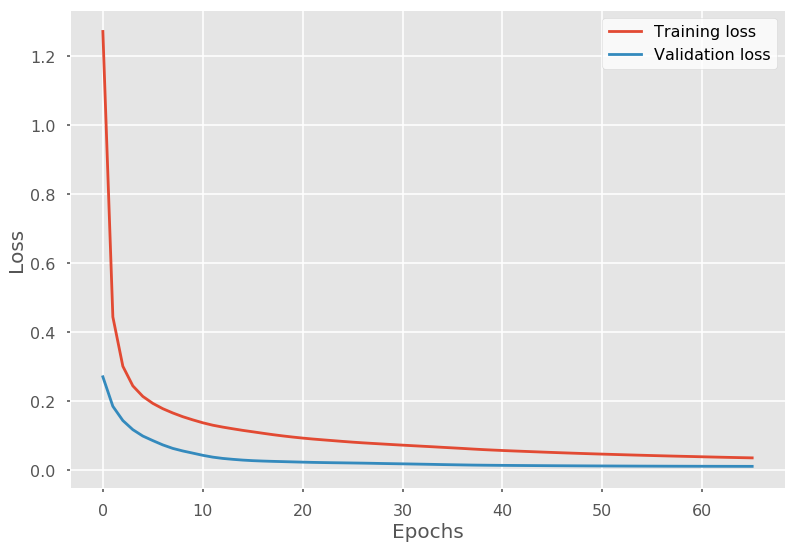

In [33]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(("Training loss", "Validation loss"), facecolor="white")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
# plt.savefig('./Figs/early_stopping.png', bbox_inches='tight')